In [ ]:
from google.colab import drive
import os
import torch
import torch.nn as nn
import torchvision.transforms as T
import torch.nn.functional as F
from torchvision import datasets
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset, Subset
from matplotlib import pyplot as plt
import random
import torch.optim as optim
import time
import numpy as np
import itertools as it

In [ ]:
print(f"CUDA is available? {torch.cuda.is_available()}")
dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(dev)

CUDA is available? True
cuda


In [ ]:
drive.mount("/content/drive",True)
root_dir = "/content/drive/My Drive/SB3/"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
def squash(s, dim=-1):
	squared_norm = torch.sum(s**2, dim=dim, keepdim=True)
	return squared_norm / (1 + squared_norm) * s / (torch.sqrt(squared_norm) + 1e-8)

In [ ]:
class PrimaryCapsules(nn.Module):
  def __init__(self, in_channels, out_channels, vector_length, kernel_size, stride, padding):
    super().__init__()
    self.vector_length = vector_length
    self.num_caps_channels = int(out_channels / vector_length)
    self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding)

  def forward(self, x):
    x = self.conv(x)
    x = x.view(x.size(0), self.num_caps_channels, x.size(2), x.size(3), self.vector_length)
    x = x.view(x.size(0), -1, self.vector_length)
    return squash(x)

In [ ]:
class RoutingCapsules(nn.Module):
  def __init__(self, in_vector_length, num_in_caps, num_out_caps, out_vector_length, num_routing):
    super().__init__()
    self.in_vector_length = in_vector_length
    self.num_in_caps = num_in_caps
    self.num_out_caps = num_out_caps
    self.out_vector_length = out_vector_length
    self.num_routing = num_routing

    self.W = nn.Parameter(torch.randn(1, num_out_caps, num_in_caps, out_vector_length, in_vector_length ) )
  
  def forward(self, x):
    batch_size = x.size(0)
    # (batch_size, num_in_caps, in_vector_length) -> (batch_size, 1, num_in_caps, in_vector_length, 1)
    x = x.unsqueeze(1).unsqueeze(4)
    #
    # W @ x =
    # (1, num_output_caps, num_in_caps, out_vector_length, in_vector_length) @ (batch_size, 1, num_in_caps, in_vector_length, 1) =
    # (batch_size, num_out_caps, num_in_caps, out_vector_length, 1)
    u_hat = torch.matmul(self.W, x)
    # (batch_size, num_out_caps, num_in_caps, out_vector_length)
    u_hat = u_hat.squeeze(-1)
    # detach u_hat during routing iterations to prevent gradients from flowing
    temp_u_hat = u_hat.detach()

    '''
    Procedure 1: Routing algorithm
    '''
    b = torch.zeros(batch_size, self.num_out_caps, self.num_in_caps, 1).to(dev)

    for route_iter in range(self.num_routing-1):
      # (batch_size, num_out_caps, num_in_caps, 1) -> Softmax along num_out_caps
      c = F.softmax(b, dim=1)

      # element-wise multiplication
      # (batch_size, num_out_caps, num_in_caps, 1) * (batch_size, num_in_caps, num_out_caps, out_vector_length) ->
      # (batch_size, num_out_caps, num_in_caps, out_vector_length) sum across num_in_caps ->
      # (batch_size, num_out_caps, out_vector_length)
      s = (c * temp_u_hat).sum(dim=2)
      # apply "squashing" non-linearity along dim_caps
      v = squash(s)
      # dot product agreement between the current output vj and the prediction uj|i
      # (batch_size, num_out_caps, num_in_caps, out_vector_length) @ (batch_size, num_out_caps, out_vector_length, 1)
      # -> (batch_size, num_out_caps, num_in_caps, 1)
      uv = torch.matmul(temp_u_hat, v.unsqueeze(-1))
      b += uv

    # last iteration is done on the original u_hat, without the routing weights update
    c = F.softmax(b, dim=1)
    s = (c * u_hat).sum(dim=2)
    # apply "squashing" non-linearity along dim_caps
    v = squash(s)

    return v

In [ ]:
class Reconstruction(nn.Module):
    def __init__(self, num_classes, vector_length):
      super().__init__()
      
      self.fc_layer = nn.Sequential(
        nn.Linear(num_classes*vector_length, 64),
        nn.ReLU()
      )

      self.reconstruction_layers = nn.Sequential(
          nn.ConvTranspose2d(1, 128, kernel_size=5, padding=2, stride=4),
          nn.ReLU(),
          nn.BatchNorm2d(128),
          nn.ConvTranspose2d(128, 64, kernel_size=5, padding=2, stride=3),
          nn.ReLU(),
          nn.BatchNorm2d(64),
          nn.ConvTranspose2d(64, 32, kernel_size=5, padding=2, stride=3),
          nn.ReLU(),
          nn.BatchNorm2d(32),
          nn.Conv2d(32, 3, kernel_size=4, padding=3, stride=1),
          nn.Sigmoid()
    )
        
    def forward(self, x):
      x = self.fc_layer(x)
      x = x.view(x.size(0), 1, 8, 8)
      x = self.reconstruction_layers(x)
      return x

In [ ]:
class CapsNet(nn.Module):
    def __init__(self, num_classes):
      super().__init__()
      self.conv_layer = nn.Sequential(
          nn.Conv2d(3, 64, kernel_size=5, padding=2, stride=4),
          nn.ReLU(),
          nn.BatchNorm2d(64),
          nn.MaxPool2d(kernel_size=5, padding=2, stride=2)
      )
      self.primary_caps = PrimaryCapsules(in_channels=64, out_channels=128, vector_length=8, kernel_size=5, padding=2, stride=1)
      self.digit_caps = nn.Sequential(
        RoutingCapsules(in_vector_length=8, num_in_caps=16384, num_out_caps=20, out_vector_length=16, num_routing=3),
        RoutingCapsules(in_vector_length=16, num_in_caps=20, num_out_caps=num_classes, out_vector_length=16, num_routing=3)
      )
      self.reconstruction_layer = Reconstruction(num_classes=num_classes, vector_length=16)
    
    def forward(self, x):
      x = self.conv_layer(x)
      x = self.primary_caps(x)
      x = self.digit_caps(x)
      scores = torch.norm(x,dim=-1)
      x = x.view(x.size(0), x.size(1) * x.size(2))
      reconstructions = self.reconstruction_layer(x)
      return scores, reconstructions

In [ ]:
def margin_loss(pred, labels, num_classes, m_plus=0.9, m_minus=0.1, loss_lambda=0.5):
  one_hot_labels = F.one_hot(labels,num_classes = num_classes)
  loss = one_hot_labels * F.relu(m_plus - pred)**2 + loss_lambda * (1 - one_hot_labels) * F.relu(pred - m_minus)**2
  loss = loss.sum(dim=1)
  return loss.mean()

In [ ]:
def train_model(epochs, dev, num_classes, loaders, lr=0.001, reconstruction_loss_scale=5e-1):
    try:
        # Create model
        model = CapsNet(num_classes=num_classes)
        model = model.to(dev)
        # Optimizer
        optimizer = optim.Adam(model.parameters(), lr=lr)
        # Initialize history
        history_loss = {"train": [], "val": [], "test": []}
        history_accuracy = {"train": [], "val": [], "test": []}
        # Initialize best validation accuracy and test accuracy at best validation accuracy
        best_val_accuracy = 0.0
        test_accuracy_at_best_val = 0.0
        best_val_per_class_accuracy = torch.zeros(num_classes).to(dev)
        test_per_class_accuracy_at_best_val = torch.zeros(num_classes).to(dev)
        batch_confusion_matrix = torch.zeros(num_classes, num_classes , dtype=torch.int64).to(dev)
        # Process each epoch
        for epoch in range(epochs):
            # Initialize epoch variables
            sum_loss = {"train": 0, "val": 0, "test": 0}
            sum_accuracy = {"train": 0, "val": 0, "test": 0}
            confusion_matrix = {"train": torch.zeros(num_classes, num_classes , dtype=torch.int64).to(dev), "val": torch.zeros(num_classes, num_classes , dtype=torch.int64).to(dev), "test": torch.zeros(num_classes, num_classes , dtype=torch.int64).to(dev)}
            # Process each split
            for split in ["train", "val", "test"]:
                if split == "train":
                  model.train()
                else:
                  model.eval()
                # Process each batch
                for (input, labels) in loaders[split]:
                    # Move to CUDA
                    input = input.to(dev)
                    labels = labels.to(dev)
                    # Reset gradients
                    optimizer.zero_grad()
                    # Compute output
                    pred, reconstructions = model(input)
                    #score_loss = F.cross_entropy(pred, labels, weight=weights)
                    score_loss = margin_loss(pred, labels, num_classes, m_plus=0.9, m_minus=0.1, loss_lambda=0.5)
                    reconstruction_loss = F.mse_loss(input, reconstructions) * reconstruction_loss_scale
                    loss = score_loss + reconstruction_loss
                    # Update loss
                    sum_loss[split] += loss.item()
                    # Check parameter update
                    if split == "train":
                        # Compute gradients
                        loss.backward()
                        # Optimize
                        optimizer.step()
                    # Compute accuracy
                    _,pred_labels = pred.max(1)
                    batch_accuracy = (pred_labels == labels).sum().item()/input.size(0)
                    # Update accuracy
                    sum_accuracy[split] += batch_accuracy
                    #Update Confusion Matrix
                    for label, pred_label in zip(labels.view(-1), pred_labels.view(-1)):
                      confusion_matrix[split][label, pred_label] += 1
            # Compute epoch loss/accuracy
            epoch_loss = {split: sum_loss[split]/len(loaders[split]) for split in ["train", "val", "test"]}
            epoch_accuracy = {split: sum_accuracy[split]/len(loaders[split]) for split in ["train", "val", "test"]}
            # Update history
            for split in ["train", "val", "test"]:
                history_loss[split].append(epoch_loss[split])
                history_accuracy[split].append(epoch_accuracy[split])
            # Print info
            print(f"Epoch {epoch+1}:",
                  f"TrL={epoch_loss['train']:.4f},",
                  f"TrA={epoch_accuracy['train']:.4f},",
                  f"VL={epoch_loss['val']:.4f},",
                  f"VA={epoch_accuracy['val']:.4f},",
                  f"TeL={epoch_loss['test']:.4f},",
                  f"TeA={epoch_accuracy['test']:.4f},\n"
                )
            # Check if we obtained the best validation accuracy
            if best_val_accuracy == 0.0 or epoch_accuracy["val"] > best_val_accuracy:
              # Update best validation accuracy and test accuracy at best validation
              best_val_accuracy = epoch_accuracy["val"]
              test_accuracy_at_best_val = epoch_accuracy["test"]
              best_val_per_class_accuracy = confusion_matrix['val'].diag()/confusion_matrix['val'].sum(1).double()
              test_per_class_accuracy_at_best_val = confusion_matrix['test'].diag()/confusion_matrix['test'].sum(1).double()
            #Print per-class accuracy
            print(f"Training per-class accuracy: {(confusion_matrix['train'].diag()/confusion_matrix['train'].sum(1).double()).tolist()}")
            print(f"Validation per-class accuracy: {(confusion_matrix['val'].diag()/confusion_matrix['val'].sum(1).double()).tolist()}")
            print(f"Test per-class accuracy: {(confusion_matrix['test'].diag()/confusion_matrix['test'].sum(1).double()).tolist()} \n")
            print(f"----------------------------------")
    except KeyboardInterrupt:
        print("Interrupted")
    finally:
        # Print best validation accuracy and test accuracy at best validation 
        print(f"Best validation accuracy: {best_val_accuracy}")
        print(f"Test accuracy at best validation: {test_accuracy_at_best_val}")
        print(f"Best per-class validation accuracy: {best_val_per_class_accuracy.tolist()}")
        print(f"Test per-class accuracy at best validation: {test_per_class_accuracy_at_best_val.tolist()}")
        # Plot loss
        plt.title("Loss")
        for split in ["train", "val", "test"]:
            plt.plot(history_loss[split], label=split)
        plt.legend()
        plt.show()
        # Plot accuracy
        plt.title("Accuracy")
        for split in ["train", "val", "test"]:
            plt.plot(history_accuracy[split], label=split)
        plt.legend()
        plt.show()
        return(best_val_accuracy, test_accuracy_at_best_val, best_val_per_class_accuracy, test_per_class_accuracy_at_best_val)

In [ ]:
class WrapperDataset(Dataset):
  def __init__(self, dataset, map_fn):
    self.dataset = dataset
    self.map = map_fn
  
  def __getitem__(self, index):
    return (self.map(self.dataset[index][0]), self.dataset[index][1])

  def __len__(self):
    return len(self.dataset)

In [ ]:
test_transform = T.Compose([
    T.Resize(320),
    T.CenterCrop(256),
    T.ToTensor()
])

In [ ]:
train_dataset = ImageFolder(os.path.join(root_dir, "train"))
test_dataset = ImageFolder(os.path.join(root_dir, "test"), transform=test_transform)
num_classes = len(train_dataset.classes)
print(num_classes)

8


In [ ]:
print(len(train_dataset))
print(len(test_dataset))

1109
471


In [ ]:
val_frac = 0.2
class_counts = [train_dataset.targets.count(i) for i in range(num_classes)]
train_counts = [x-int(x*val_frac) for x in class_counts]
print(f"Train counts {train_counts}")
val_counts = [int(x*val_frac) for x in class_counts]
print(f"Val counts {val_counts}")
test_counts = [test_dataset.targets.count(i) for i in range(num_classes)]
print(f"Test counts {test_counts}")

Train counts [400, 23, 31, 93, 14, 16, 272, 42]
Val counts [100, 5, 7, 23, 3, 3, 67, 10]
Test counts [214, 12, 16, 49, 6, 7, 145, 22]


In [ ]:
def train(train_dataset, test_dataset, train_transform, test_transform, val_frac, num_classes, epochs):
  num_train = len(train_dataset)
  idx = list(range(num_train))
  idx_iter = iter(idx)
  class_idx = [list(it.islice(idx_iter, x)) for x in class_counts]
  class_idx = [random.sample(x,len(x)) for x in class_idx]
  train_idx = [x[:-int(len(x)*val_frac)] for x in class_idx]
  train_idx = list(it.chain.from_iterable(train_idx))
  val_idx = [x[-int(len(x)*val_frac):] for x in class_idx]
  val_idx = list(it.chain.from_iterable(val_idx))
  val_dataset = Subset(train_dataset,val_idx)
  train_dataset = Subset(train_dataset, train_idx)

  train_dataset = WrapperDataset(train_dataset,train_transform)
  val_dataset = WrapperDataset(val_dataset,test_transform)

  train_loader = DataLoader(train_dataset, batch_size=4, num_workers=4, shuffle=True)
  val_loader = DataLoader(val_dataset, batch_size=4, num_workers=4, shuffle=False)
  test_loader = DataLoader(test_dataset,   batch_size=4, num_workers=4, shuffle=False)
  loaders = {
    "train": train_loader,
    "val" : val_loader,
    "test": test_loader
  }

  return train_model(epochs, dev, num_classes, loaders, lr=0.001, reconstruction_loss_scale=5e-1)


Epoch 1: TrL=0.9275, TrA=0.3322, VL=0.5749, VA=0.3091, TeL=0.5679, TeA=0.3114,

Training per-class accuracy: [0.365, 0.043478260869565216, 0.0, 0.15053763440860216, 0.07142857142857142, 0.0, 0.4852941176470588, 0.047619047619047616]
Validation per-class accuracy: [0.02, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9850746268656716, 0.0]
Test per-class accuracy: [0.014018691588785047, 0.0, 0.0, 0.0, 0.0, 0.0, 0.993103448275862, 0.0] 

----------------------------------
Epoch 2: TrL=0.4584, TrA=0.3984, VL=0.4175, VA=0.4227, TeL=0.4100, TeA=0.4047,

Training per-class accuracy: [0.615, 0.0, 0.0, 0.053763440860215055, 0.0, 0.0, 0.38235294117647056, 0.0]
Validation per-class accuracy: [0.85, 0.0, 0.0, 0.0, 0.0, 0.0, 0.11940298507462686, 0.0]
Test per-class accuracy: [0.794392523364486, 0.16666666666666666, 0.0, 0.0, 0.0, 0.0, 0.1310344827586207, 0.0] 

----------------------------------
Epoch 3: TrL=0.4283, TrA=0.3999, VL=0.3841, VA=0.4591, TeL=0.3838, TeA=0.4534,

Training per-class accuracy: [0.6375, 0.043

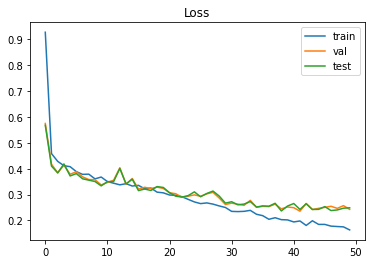

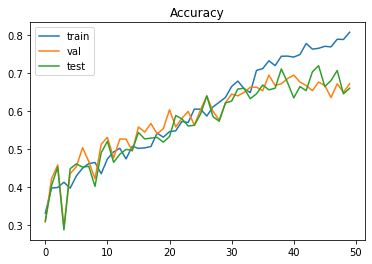

--------------------------------------------------
Epoch 1: TrL=0.8972, TrA=0.3632, VL=0.4926, VA=0.4364, TeL=0.4957, TeA=0.4153,

Training per-class accuracy: [0.595, 0.0, 0.0, 0.07526881720430108, 0.0, 0.0625, 0.2867647058823529, 0.0]
Validation per-class accuracy: [0.81, 0.0, 0.0, 0.0, 0.0, 0.0, 0.22388059701492538, 0.0]
Test per-class accuracy: [0.719626168224299, 0.0, 0.0, 0.0, 0.16666666666666666, 0.0, 0.2827586206896552, 0.0] 

----------------------------------
Epoch 2: TrL=0.4648, TrA=0.4073, VL=0.3954, VA=0.4545, TeL=0.3953, TeA=0.4534,

Training per-class accuracy: [0.6825, 0.0, 0.0, 0.021505376344086023, 0.0, 0.0, 0.3235294117647059, 0.0]
Validation per-class accuracy: [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Test per-class accuracy: [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] 

----------------------------------
Epoch 3: TrL=0.4355, TrA=0.4141, VL=0.3893, VA=0.4227, TeL=0.3899, TeA=0.4089,

Training per-class accuracy: [0.7075, 0.0, 0.0, 0.043010752688172046, 0.0, 0.0, 0.3014

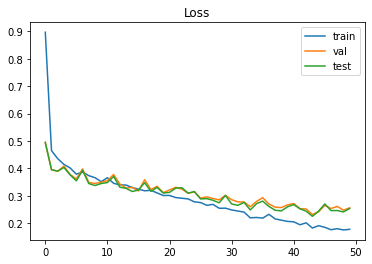

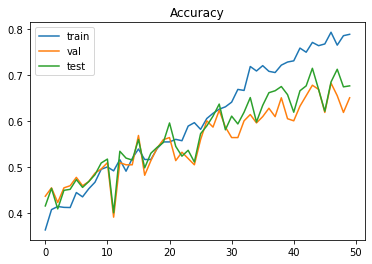

--------------------------------------------------
Epoch 1: TrL=0.9456, TrA=0.3259, VL=0.5127, VA=0.3045, TeL=0.5336, TeA=0.3136,

Training per-class accuracy: [0.4975, 0.043478260869565216, 0.03225806451612903, 0.043010752688172046, 0.0, 0.0, 0.30514705882352944, 0.047619047619047616]
Validation per-class accuracy: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]
Test per-class accuracy: [0.0, 0.25, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0] 

----------------------------------
Epoch 2: TrL=0.4580, TrA=0.4032, VL=0.4073, VA=0.4364, TeL=0.3987, TeA=0.4534,

Training per-class accuracy: [0.6475, 0.0, 0.0, 0.06451612903225806, 0.0, 0.0, 0.34558823529411764, 0.0]
Validation per-class accuracy: [0.79, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2537313432835821, 0.0]
Test per-class accuracy: [0.7523364485981309, 0.0, 0.0, 0.0, 0.0, 0.0, 0.36551724137931035, 0.0] 

----------------------------------
Epoch 3: TrL=0.4149, TrA=0.4040, VL=0.3917, VA=0.3591, TeL=0.3844, TeA=0.3729,

Training per-class accuracy: [0.6875, 0.0, 0.0, 0.

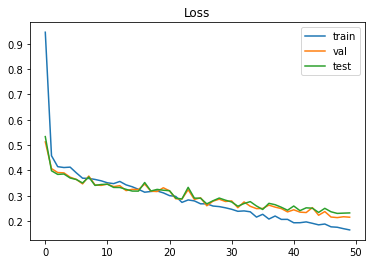

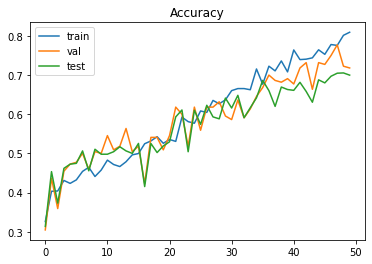

--------------------------------------------------
Mean best validation accuracy: 0.7181818181818181
Mean test accuracy at best validation: 0.6819679849340866
Mean best per-class validation accuracy: [0.8766667246818542, 0.9333333373069763, 0.4761905074119568, 0.5362318754196167, 0.444444477558136, 0.5555555820465088, 0.641791045665741, 0.30000001192092896]
Mean test per-class accuracy at best validation: [0.8115264773368835, 0.8611111044883728, 0.1666666716337204, 0.5646258592605591, 0.5555555820465088, 0.6666666865348816, 0.5954023599624634, 0.560606062412262]


In [ ]:
#Without train transformations

train_transform = T.Compose([
    T.Resize(320),
    T.RandomCrop(256),
    T.ToTensor()
])

k = 3
sum_best_val_accuracy = 0.0
sum_test_accuracy_at_best_val = 0.0
sum_best_val_per_class_accuracy = torch.zeros(num_classes).to(dev)
sum_test_per_class_accuracy_at_best_val = torch.zeros(num_classes).to(dev)
for _ in range(k):
  best_val_accuracy, test_accuracy_at_best_val, best_val_per_class_accuracy, test_per_class_accuracy_at_best_val = train(train_dataset, test_dataset, train_transform, test_transform, val_frac, num_classes,50)
  sum_best_val_accuracy += best_val_accuracy
  sum_test_accuracy_at_best_val += test_accuracy_at_best_val
  sum_best_val_per_class_accuracy += best_val_per_class_accuracy
  sum_test_per_class_accuracy_at_best_val += test_per_class_accuracy_at_best_val
  print("--------------------------------------------------")

# Print best validation accuracy and test accuracy at best validation 
print(f"Mean best validation accuracy: {sum_best_val_accuracy / k}")
print(f"Mean test accuracy at best validation: {sum_test_accuracy_at_best_val / k}")
print(f"Mean best per-class validation accuracy: {(sum_best_val_per_class_accuracy / k).tolist()}")
print(f"Mean test per-class accuracy at best validation: {(sum_test_per_class_accuracy_at_best_val / k).tolist()}")

Epoch 1: TrL=0.9398, TrA=0.3199, VL=0.4205, VA=0.3500, TeL=0.4096, TeA=0.3623,

Training per-class accuracy: [0.43, 0.0, 0.03225806451612903, 0.010752688172043012, 0.0, 0.0, 0.40441176470588236, 0.023809523809523808]
Validation per-class accuracy: [0.17, 0.0, 0.0, 0.0, 0.0, 0.0, 0.8955223880597015, 0.0]
Test per-class accuracy: [0.16822429906542055, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9310344827586207, 0.0] 

----------------------------------
Epoch 2: TrL=0.4782, TrA=0.3808, VL=0.3761, VA=0.4500, TeL=0.3779, TeA=0.4449,

Training per-class accuracy: [0.645, 0.0, 0.0, 0.06451612903225806, 0.0, 0.0, 0.2757352941176471, 0.0]
Validation per-class accuracy: [0.97, 0.0, 0.0, 0.0, 0.0, 0.0, 0.029850746268656716, 0.0]
Test per-class accuracy: [0.9532710280373832, 0.0, 0.0, 0.0, 0.0, 0.0, 0.041379310344827586, 0.0] 

----------------------------------
Epoch 3: TrL=0.4506, TrA=0.3860, VL=0.5197, VA=0.3045, TeL=0.5080, TeA=0.3072,

Training per-class accuracy: [0.6375, 0.0, 0.0, 0.03225806451612903, 0.0,

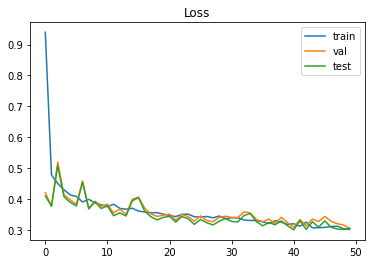

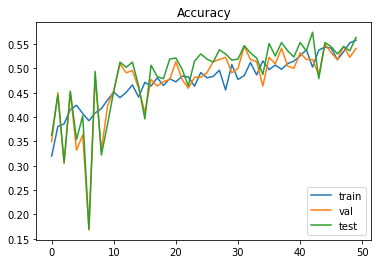

--------------------------------------------------
Epoch 1: TrL=0.8924, TrA=0.3898, VL=0.4864, VA=0.4455, TeL=0.4858, TeA=0.4513,

Training per-class accuracy: [0.7225, 0.0, 0.0, 0.0, 0.0, 0.0, 0.20955882352941177, 0.023809523809523808]
Validation per-class accuracy: [0.98, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Test per-class accuracy: [0.9953271028037384, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] 

----------------------------------
Epoch 2: TrL=0.4930, TrA=0.3733, VL=0.4175, VA=0.3864, TeL=0.4348, TeA=0.3581,

Training per-class accuracy: [0.615, 0.0, 0.0, 0.010752688172043012, 0.0, 0.0, 0.3125, 0.0]
Validation per-class accuracy: [0.55, 0.0, 0.0, 0.08695652173913043, 0.0, 0.0, 0.417910447761194, 0.0]
Test per-class accuracy: [0.5700934579439252, 0.0, 0.0, 0.02040816326530612, 0.0, 0.0, 0.31724137931034485, 0.0] 

----------------------------------
Epoch 3: TrL=0.4288, TrA=0.3797, VL=0.3798, VA=0.4545, TeL=0.3773, TeA=0.4534,

Training per-class accuracy: [0.65, 0.0, 0.0, 0.021505376344086023,

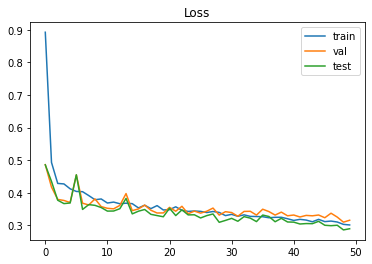

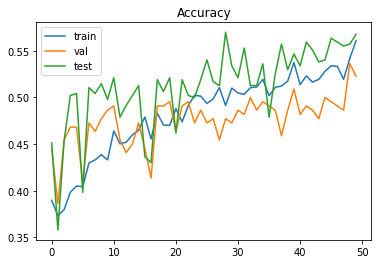

--------------------------------------------------
Epoch 1: TrL=0.8980, TrA=0.3786, VL=0.4539, VA=0.4409, TeL=0.4426, TeA=0.4280,

Training per-class accuracy: [0.69, 0.0, 0.0, 0.010752688172043012, 0.07142857142857142, 0.0, 0.21691176470588236, 0.0]
Validation per-class accuracy: [0.92, 0.0, 0.0, 0.0, 0.0, 0.0, 0.07462686567164178, 0.0]
Test per-class accuracy: [0.8644859813084113, 0.0, 0.0, 0.0, 0.0, 0.0, 0.11724137931034483, 0.0] 

----------------------------------
Epoch 2: TrL=0.4657, TrA=0.3830, VL=0.4974, VA=0.4409, TeL=0.4975, TeA=0.4470,

Training per-class accuracy: [0.6925, 0.043478260869565216, 0.0, 0.021505376344086023, 0.0, 0.0, 0.22058823529411764, 0.023809523809523808]
Validation per-class accuracy: [0.97, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Test per-class accuracy: [0.985981308411215, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] 

----------------------------------
Epoch 3: TrL=0.4183, TrA=0.4249, VL=0.4167, VA=0.4273, TeL=0.4192, TeA=0.4237,

Training per-class accuracy: [0.7625

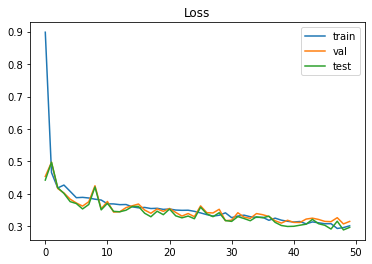

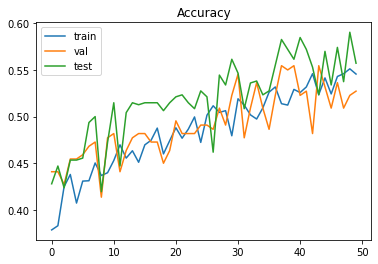

--------------------------------------------------
Mean best validation accuracy: 0.546969696969697
Mean test accuracy at best validation: 0.5642655367231638
Mean best per-class validation accuracy: [0.8733333349227905, 0.46666666865348816, 0.0, 0.043478261679410934, 0.222222238779068, 0.0, 0.43283581733703613, 0.0]
Mean test per-class accuracy at best validation: [0.8785046935081482, 0.5833333730697632, 0.0, 0.07482993602752686, 0.111111119389534, 0.0, 0.45747125148773193, 0.03030303120613098]


In [ ]:
#With train transformations
train_transform = T.Compose([
    T.Resize(320),
    T.RandomCrop(256),
    T.RandomHorizontalFlip(),
    T.RandomVerticalFlip(),
    T.ToTensor()
])

k = 3
sum_best_val_accuracy = 0.0
sum_test_accuracy_at_best_val = 0.0
sum_best_val_per_class_accuracy = torch.zeros(num_classes).to(dev)
sum_test_per_class_accuracy_at_best_val = torch.zeros(num_classes).to(dev)
for _ in range(k):
  best_val_accuracy, test_accuracy_at_best_val, best_val_per_class_accuracy, test_per_class_accuracy_at_best_val = train(train_dataset, test_dataset, train_transform, test_transform, val_frac, num_classes,50)
  sum_best_val_accuracy += best_val_accuracy
  sum_test_accuracy_at_best_val += test_accuracy_at_best_val
  sum_best_val_per_class_accuracy += best_val_per_class_accuracy
  sum_test_per_class_accuracy_at_best_val += test_per_class_accuracy_at_best_val
  print("--------------------------------------------------")

# Print best validation accuracy and test accuracy at best validation 
print(f"Mean best validation accuracy: {sum_best_val_accuracy / k}")
print(f"Mean test accuracy at best validation: {sum_test_accuracy_at_best_val / k}")
print(f"Mean best per-class validation accuracy: {(sum_best_val_per_class_accuracy / k).tolist()}")
print(f"Mean test per-class accuracy at best validation: {(sum_test_per_class_accuracy_at_best_val / k).tolist()}")